In [1]:
import sys
sys.path.append('../../')

from amplify.client import FixstarsClient
from matplotlib import pyplot as plt
import numpy as np
import os
import tikzplotlib

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator import MeshDiffuser
from optimizer import Annealing, AnnealingSolver, PolyTop
from problems.topo_opt_level_set_fluid_flow import TopologyOptimizationProblem

# Topology Optimization for Diffuser Problem

In [2]:
output_path = '/usr2/key/Projects/QuantumAnnealing/TopoFlowManuscript/fig/comparison/diffuser'

## Computational Mesh

In [3]:
# Create Meshes for Diffuser Problem.
n_elem_for_width = 32
n_elem_for_height = 32
mesh_v = MeshDiffuser('Q2', n_elem_for_width, n_elem_for_height, width=1., height=1., outlet_height=1./3.)
mesh_p = MeshDiffuser('Q1', n_elem_for_width, n_elem_for_height, width=1., height=1., outlet_height=1./3.)

## Finite Element Model

### Boundary Conditions

In [4]:
def inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 4*(1.-y)*y; v_y = 0.0
    return np.array([v_x, v_y])

In [5]:
def outlet_velocity(mesh, i_node, width):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 0.0; v_y = 0.0
    return np.array([v_x,v_y])

In [6]:
# Compute boundary velocities.
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}
for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet':
            boundary_velocity[boundary].append(inlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))

# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        if boundary == 'inlet' or boundary == 'wall' :
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
        elif boundary == 'outlet':
            # Parallel outflow, i.e., no vertical velocity.
            BC.append([node, 1, 0.0])
boundary_values_v = np.array(BC)

### Material Properties

In [40]:
viscosity = 1. 
density = 1.

# 
epsilon = 8.e-2

alpha_bar = viscosity/epsilon
print(alpha_bar)

12.5


### Finite Element Model

In [8]:
fem = FEM(mesh_v, mesh_p, viscosity, density, epsilon)
fem.set_boudary_values_v(boundary_values_v)

Objective Function:0.0028356281238802027


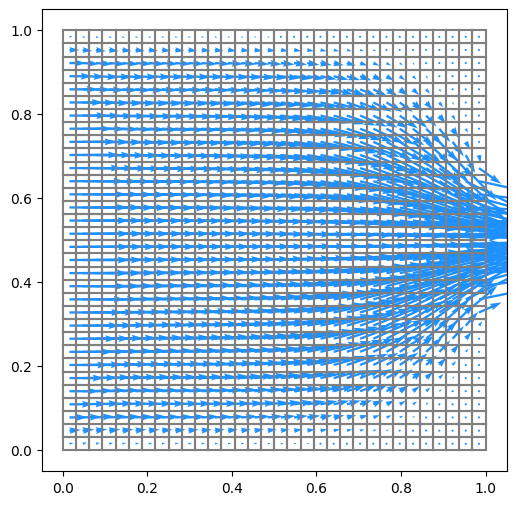

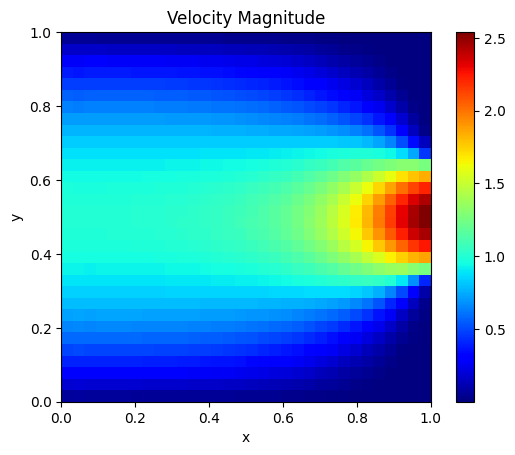

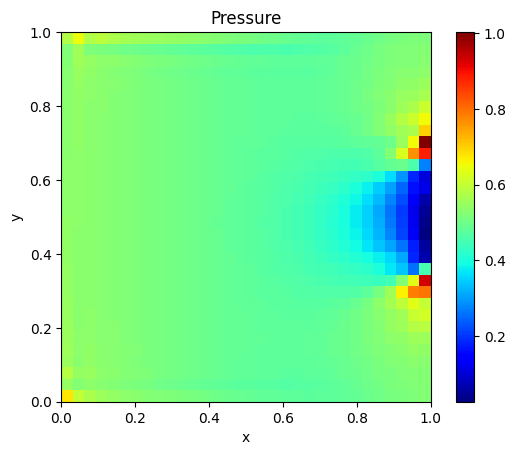

In [9]:
U, u_e, v_e, p_e, F, f=fem.solve()
objective_initial = F
volume_fraction_initial = 1.0
print(f'Objective Function:{f}')
fem.plot_velocity_field([u_e, v_e])
fem.plot_velocity_magnitude([u_e, v_e])
fem.plot_pressure(p_e)

## Optimization

In [10]:
# Settings for Optimization.
volume_fraction_max = 0.5 # Volume fraction.
design_tolerance = 0.01 # Convergence tolerance on design variables.

active = {'classic': True,
          'annealing': True}

### Classical Optimization

In [11]:
density_initial = np.ones(mesh_v.n_elem) # Initial density, i.e., design variables, for each element.
density_min = 0.0; density_max = 1.0 # Lower and upper bound for design variables.

max_iterations = 150 # Max. number of optimization steps.

opt_OCMove = 0.2  # Allowable move step in OC update scheme
opt_OCEta = 0.5  # Exponent used in OC update scheme

q_values = [0.01, 0.1, 1.] #

############### q = 0.01 ###############
Iteration: 1, Objective Function: 0.0028356281238802027, Volume Fraction: 0.8000000000000002
1.0
Iteration: 2, Objective Function: 0.013074139678370261, Volume Fraction: 0.5999999999999999
3.610667939235958
Iteration: 3, Objective Function: 0.028868651100458092, Volume Fraction: 0.499989219033465
1.208072715348003
Iteration: 4, Objective Function: 0.030145991755942507, Volume Fraction: 0.5000603635978679
0.04424663456007981
Iteration: 5, Objective Function: 0.019885346699445923, Volume Fraction: 0.5000110104483686
0.3403651516780489


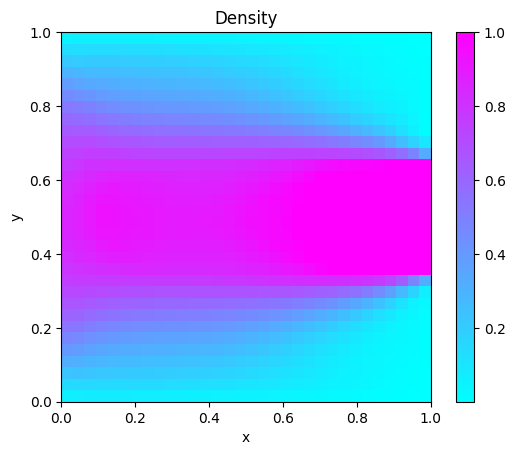

Iteration: 6, Objective Function: 0.011982562859604941, Volume Fraction: 0.49991753119221105
0.3974174531269893
Iteration: 7, Objective Function: 0.008088337101267872, Volume Fraction: 0.5000770148698959
0.3249910560840955
Iteration: 8, Objective Function: 0.007181516063976149, Volume Fraction: 0.49994528050911613
0.11211464432529351
Iteration: 9, Objective Function: 0.006939855865630391, Volume Fraction: 0.4999948120269796
0.033650303945983104
Iteration: 10, Objective Function: 0.006859107349955545, Volume Fraction: 0.49999495031584457
0.011635474459167473


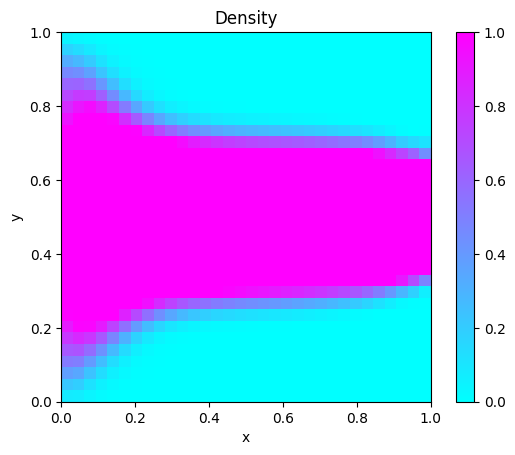

Iteration: 11, Objective Function: 0.006830863160008763, Volume Fraction: 0.4999885776739931
0.004117764674869172


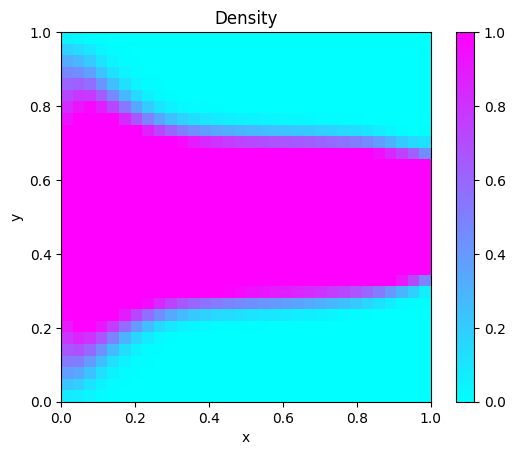

############### q = 0.1 ################
Iteration: 1, Objective Function: 0.010730826212055239, Volume Fraction: 0.4999960916331206
0.5709326860591762
Iteration: 2, Objective Function: 0.009243574904551594, Volume Fraction: 0.5000029569094007
0.1385961600825139
Iteration: 3, Objective Function: 0.00885689937841747, Volume Fraction: 0.5000005962492791
0.04183181616711108
Iteration: 4, Objective Function: 0.00877298804282824, Volume Fraction: 0.49999004401398894
0.009474120908916077


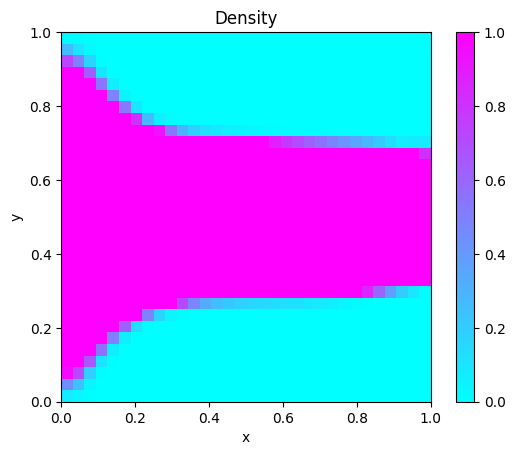

############### q = 1.0 ################
Iteration: 1, Objective Function: 0.009810340824176046, Volume Fraction: 0.49999815354026234
0.11824395249185632
Iteration: 2, Objective Function: 0.009477482971529557, Volume Fraction: 0.49999771018458894
0.03392928529314831
Iteration: 3, Objective Function: 0.009287523366068888, Volume Fraction: 0.49999989892501673
0.02004325473665421
Iteration: 4, Objective Function: 0.009197053793513963, Volume Fraction: 0.49999782147909133
0.009740979267459706


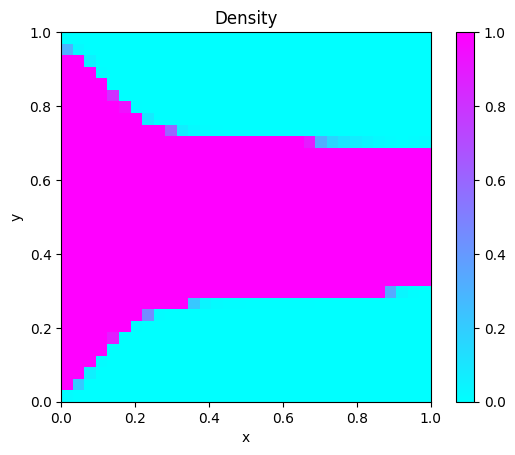

Final objective function (binary design): 0.009526348826355604, volume fraction 0.4931640625


In [12]:
poly_top = PolyTop(fem)
if active['classic']:
    density = poly_top.optimize(density_initial, density_min, density_max, volume_fraction_max,
                    design_tolerance, max_iterations, q_values,
                    opt_OCMove, opt_OCEta)
    
    binary_array = np.where(density >= 0.95, 1, 0)
    E = fem.viscosity/fem.epsilon*(1-binary_array)
    _, u, v, _, _, f = fem.solve(E)
    print(f'Final objective function (binary design): {f}, volume fraction {sum(binary_array)/mesh_p.area}')

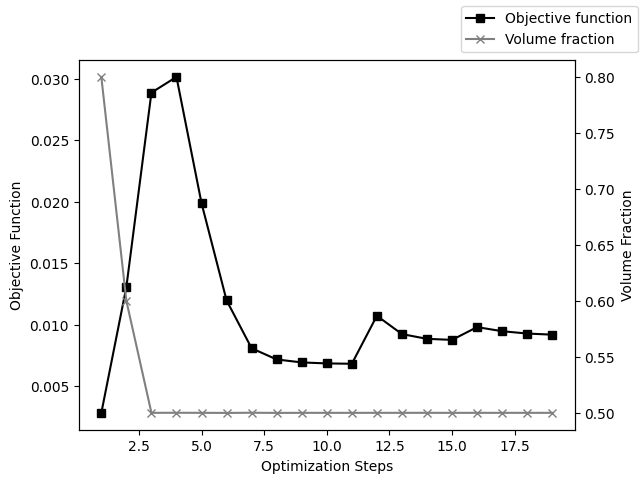

In [13]:
if active['classic']:
    poly_top.plot_history()

### Optimization with Ising Machine Formulation

In [14]:
# Annealing Solver.
client = FixstarsClient()
client.parameters.timeout = 1000
client.parameters.outputs.duplicate = True
if os.path.exists('token_Fixstars.txt'):
    client.token = open('token_Fixstars.txt',"r").read().replace('\n', '')
if os.path.exists('proxy.txt'):
    client.proxy = open('proxy.txt',"r").read().replace('\n', '')

annealing_solver = AnnealingSolver(client)

In [15]:
# Topology Optimization Problem in Ising Machine Formulation.
n_qubits_per_variable = 9

hyperparameters = {
        'energy_dissipation': 3.e3,
        'regularization': 50.,
        'volume_constraint': 600.,
        'char_func': 300.
}

hyperparameters = {
        'energy_dissipation': 1.,
        'regularization': 0.,
        'volume_constraint': 0.2,
        'char_func': 0.
}

topo_opt_problem = TopologyOptimizationProblem(fem.ne, n_qubits_per_variable, hyperparameters, volume_fraction_max)
topo_opt_problem.generate_discretizaton()

Iteration: 0, Objective Function: 0.025325045455265614, Volume Fraction: 0.513671875, Inconsistencies: 498


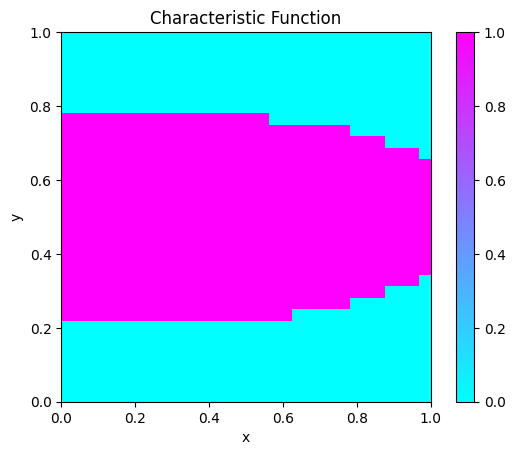

Abs. change in
	char. func.:498.0
Rel. change in
	char. func.:0.486328125
	Obj. func.: 7.931017872897752
Iteration: 1, Objective Function: 0.012358409045255868, Volume Fraction: 0.501953125, Inconsistencies: 510


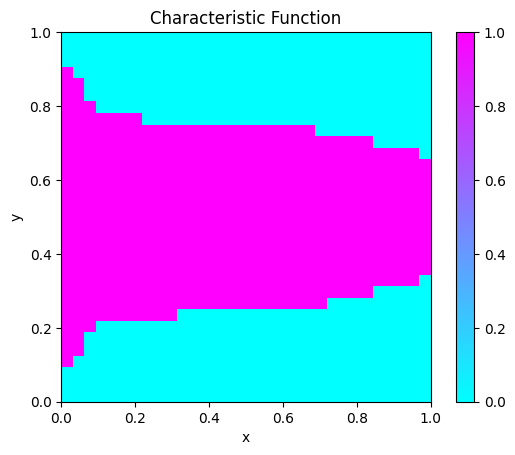

Abs. change in
	char. func.:44.0
Rel. change in
	char. func.:0.08365019011406843
	Obj. func.: 0.5120084160525646
Iteration: 2, Objective Function: 0.011357034521280174, Volume Fraction: 0.5009765625, Inconsistencies: 511


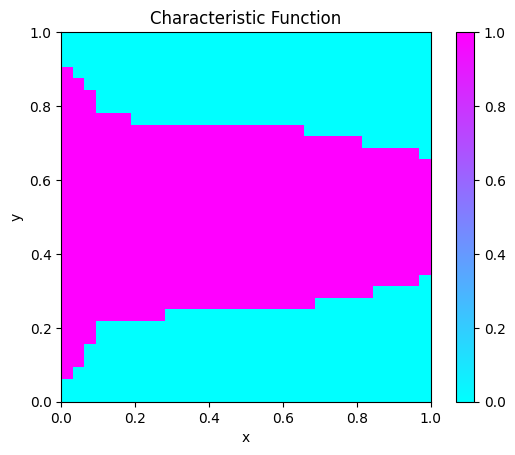

Abs. change in
	char. func.:9.0
Rel. change in
	char. func.:0.017509727626459144
	Obj. func.: 0.08102778604500879
Iteration: 3, Objective Function: 0.010674513680823183, Volume Fraction: 0.5009765625, Inconsistencies: 511


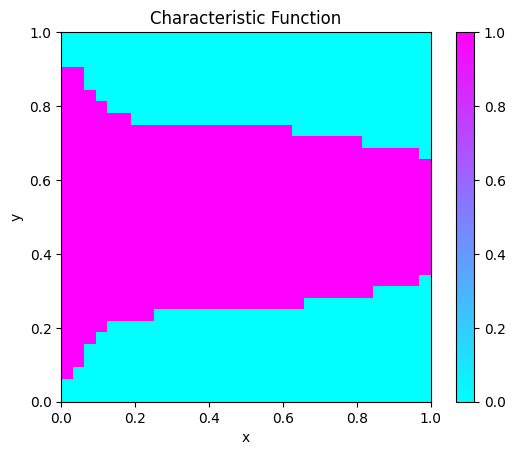

Abs. change in
	char. func.:6.0
Rel. change in
	char. func.:0.011695906432748537
	Obj. func.: 0.06009674789471864
Iteration: 4, Objective Function: 0.010290454025845329, Volume Fraction: 0.5009765625, Inconsistencies: 511


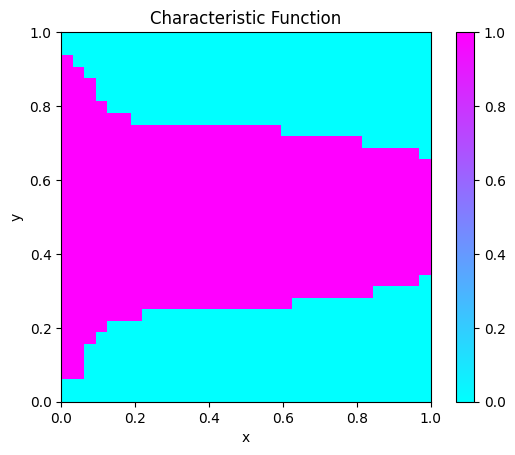

Abs. change in
	char. func.:6.0
Rel. change in
	char. func.:0.011695906432748537
	Obj. func.: 0.035979124338733966
Iteration: 5, Objective Function: 0.010142465607098135, Volume Fraction: 0.5009765625, Inconsistencies: 511


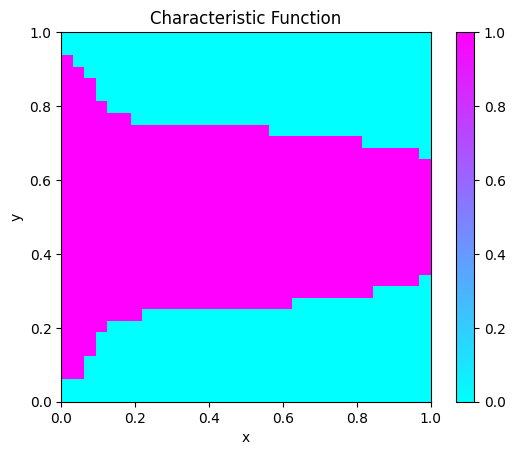

Abs. change in
	char. func.:2.0
Rel. change in
	char. func.:0.003898635477582846
	Obj. func.: 0.014381135990259315
Iteration: 6, Objective Function: 0.010084371589252884, Volume Fraction: 0.5009765625, Inconsistencies: 511


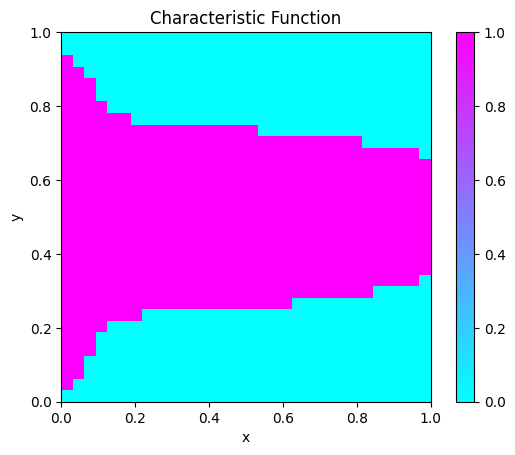

Abs. change in
	char. func.:2.0
Rel. change in
	char. func.:0.003898635477582846
	Obj. func.: 0.00572780032939865


In [16]:
# Optimization
max_opt_steps = 15
# Initial scaled level-set values, i.e., design variables, for each element.
level_set_scaled_initial = np.ones(mesh_v.n_elem) 
annealing_optimizer = Annealing(fem)
if active['annealing']:
    char_func = annealing_optimizer.optimize(annealing_solver,
                                topo_opt_problem, 
                                level_set_scaled_initial,
                                max_opt_steps,
                                design_tolerance,
                                plot_steps=True)

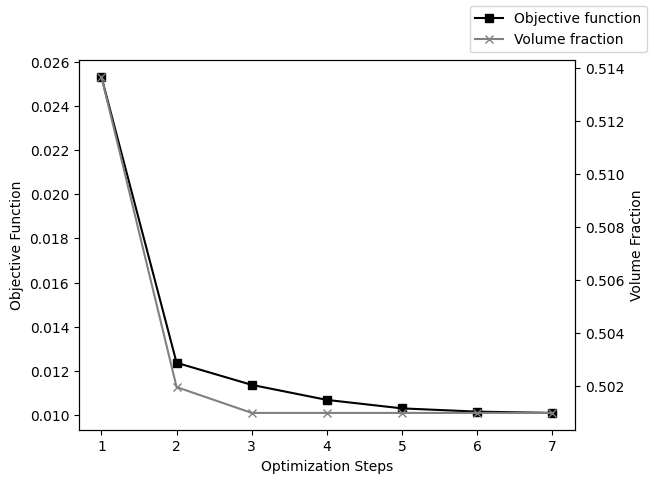

In [17]:
if active['annealing']:
    annealing_optimizer.plot_history()

In [18]:
binary_array = np.where(density >= 0.95, 1, 0)
E = fem.viscosity/fem.epsilon*(1-binary_array)
_, u, v, _, _, f = fem.solve(E)
print(f'Final objective function (binary design): {f}, volume fraction {sum(binary_array)/mesh_p.area}')

Final objective function (binary design): 0.009526348826355604, volume fraction 0.4931640625


In [38]:
# Comparison
# Number of optimization steps
n_C = len(poly_top.objective_function_list)
n_A = len(annealing_optimizer.objective_function_list)
print('Number of optimization steps:')
print('\tClassical:', n_C)
print('\tAnnealing:', n_A)
print('\tRel. Diff. (%):', (n_A-n_C)/n_C*100)
# Objective function
print('Objective function:')
print('\tClassical: '+'{:.3e}'.format(f))
print('\tAnnealing: '+'{:.3e}'.format(annealing_optimizer.objective_function))
print('\tRel. Diff (%).:', (annealing_optimizer.objective_function-f)/f*100)


Number of optimization steps:
	Classical: 19
	Annealing: 7
	Rel. Diff. (%): -63.1578947368421
Objective function:
	Classical: 9.526e-03
	Annealing: 1.008e-02
	Rel. Diff (%).: 5.857677196886323


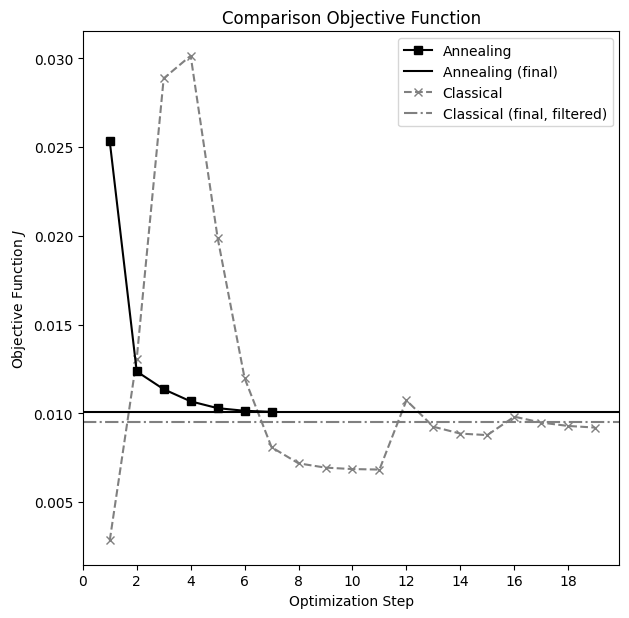

In [20]:
%matplotlib inline

# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",  # Use pdflatex or xelatex
#     "font.family": "serif",        # Use LaTeX default serif font
#     "text.usetex": True,           # Use LaTeX for all text
#     "pgf.rcfonts": False,          # Don't use matplotlib's rc settings, keep LaTeX's
# })

textwidth_in_inches = 500.484/72.27
aspect_ratio = 1.
fig, ax = plt.subplots(figsize=(textwidth_in_inches, textwidth_in_inches * aspect_ratio))
ax.set_title('Comparison Objective Function')
ax.plot(np.arange(1, len(annealing_optimizer.objective_function_list)+1),annealing_optimizer.objective_function_list,label="Annealing", marker='s', color='k',zorder=2)
ax.axhline(y=annealing_optimizer.objective_function, color='k', label='Annealing (final)', zorder=2)
ax.plot(np.arange(1, len(poly_top.objective_function_list)+1),poly_top.objective_function_list,label="Classical",marker='x',color='gray', linestyle='dashed',zorder=1)
ax.axhline(y=f, color='gray', label='Classical (final, filtered)', linestyle='dashdot',zorder=1)

natural_numbers = np.arange(0, max(len(annealing_optimizer.objective_function_list),len(poly_top.objective_function_list)),2)
plt.xticks(natural_numbers)
ax.set_xlabel('Optimization Step')
ax.set_ylabel(r'Objective Function $J$')
ax.legend(loc='best', fontsize='medium')

fig.show()

tikzplotlib.save(os.path.join(output_path, 'comparison_objective.tex'))


0.0009765625
0.5009765625
(0.09999999999999998, 19.9)


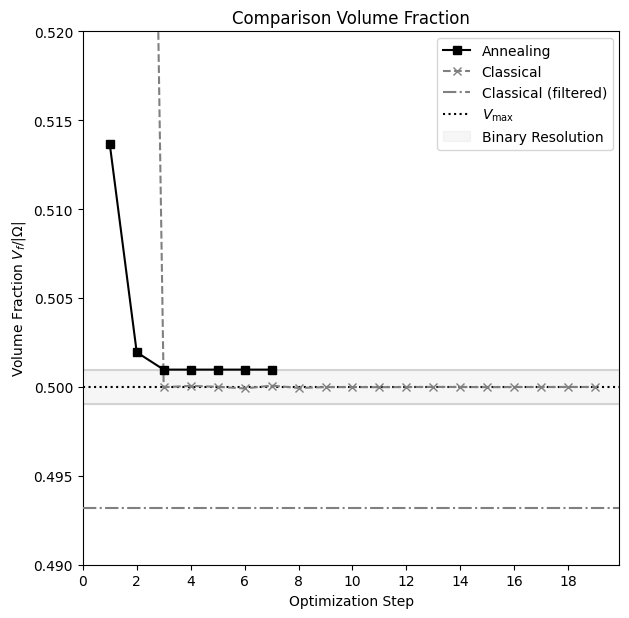

In [ ]:
dV = 1./mesh_p.n_elem
print(dV)
print(annealing_optimizer.volume_fraction)
fig, ax = plt.subplots(figsize=(textwidth_in_inches, textwidth_in_inches * aspect_ratio))
ax.set_title('Comparison Volume Fraction')
ax.plot(np.arange(1, len(annealing_optimizer.volume_fraction_list)+1), annealing_optimizer.volume_fraction_list,label='Annealing',marker='s',color='k',zorder=4)
ax.plot(np.arange(1, len(poly_top.volume_fraction_list)+1), poly_top.volume_fraction_list,label='Classical',marker='x',color='gray', linestyle='dashed',zorder=3)

# ax1.axhline(y=annealing_optimizer.volume_fraction+dV, color='orange', linestyle='dashed')
# ax1.axhline(y=annealing_optimizer.volume_fraction-dV, color='orange', linestyle='dashed')


ax.axhline(y=sum(binary_array)/mesh_p.area, label='Classical (filtered)', color='gray', linestyle='dashdot', zorder=3)
ax.axhline(y=volume_fraction_max, label=r'$V_{\mathrm{max}}$', color='k', linestyle='dotted')
x_limits = fig.gca().get_xlim()
print(x_limits)
x_fill = np.linspace(x_limits[0], x_limits[1], 100)
ax.axhline(y=volume_fraction_max+1*dV, color='lightgray')
ax.axhline(y=volume_fraction_max-1*dV, color='lightgray')
ax.fill_between(x_fill, volume_fraction_max-1*dV, volume_fraction_max+1*dV, color='lightgray', alpha=0.2, label='Binary Resolution', zorder=1)
ax.set_xlim(x_limits)
ax.set_ylim([0.49,0.52])
natural_numbers = np.arange(0, max(len(annealing_optimizer.objective_function_list),len(poly_top.objective_function_list)),2)
plt.xticks(natural_numbers)
ax.set_xlabel('Optimization Step')
ax.set_ylabel(r'Volume Fraction $V_f/|\Omega|$')
ax.legend(loc='best', fontsize='medium')
fig.show()

tikzplotlib.save(os.path.join(output_path, 'comparison_volume_fraction.tex'))

In [ ]:
print(annealing_optimizer.volume_fraction_list)

[0.513671875, 0.501953125, 0.5009765625, 0.5009765625, 0.5009765625, 0.5009765625, 0.5009765625]


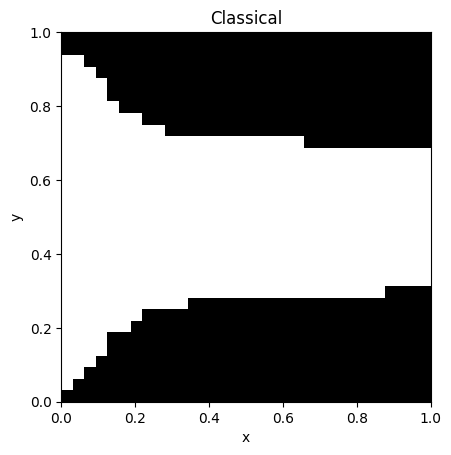

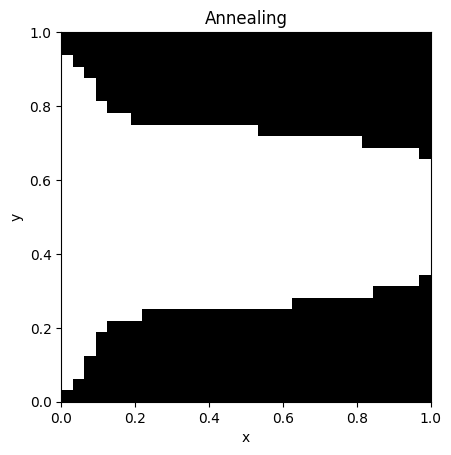

In [ ]:
file_name = None
tikz = True
title = 'Classical'
file_name = os.path.join(output_path, 'final_design_classical')
mesh_v.plot_element_quantity(binary_array, cmap='gray', cbar=False, title=title, file_name=file_name, tikz=tikz)
file_name = os.path.join(output_path, 'final_design_annealing')
title = 'Annealing'
mesh_v.plot_element_quantity(char_func, cmap='gray', cbar=False, title=title, file_name=file_name, tikz=tikz)